# Universal and Robust Multi-Modal Crack Extraction via Generalized Frangi Graphs and Topological Centrality

**Abstract**
Automatic crack detection is a pivotal task in structural health monitoring and geoscience. We propose a "universal", training-free approach that robustly extracts crack networks across varying data distributions. Our method generalizes the classical Frangi vesselness filter to the multi-modal setting, fusing photometric (intensity) and geometric (range/depth) data at the Hessian level. Instead of pixel-wise classification, we construct a sparse graph driven by a pairwise Frangi similarity metric. A novel topological extraction algorithm—combining HDBSCAN and Weighted Betweenness Centrality on a MST—isolates the precise topological skeleton.

This notebook reproduces the experiments presented in the paper (ICPR 2025, Lyon), illustrating the method on:
1.  **Real-world geological data**: The *Palais des Papes* in Avignon.
2.  **The FIND Benchmark**: A dataset of 500 registered intensity and range images.

---


In [1]:
# 1. Environment Setup
!pip -q install numpy scipy scikit-image matplotlib joblib tqdm tqdm-joblib hdbscan networkx gdown tifffile imageio pandas Pillow pot

import os
if not os.path.exists("Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset"):
    !git clone https://github.com/Ludwig-H/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset.git

%cd Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
!pip install -e .


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.7 MB/s eta 0:00:00
Cloning into 'Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 437 (delta 19), reused 22 (delta 10), pack-reused 404 (from 1)
Receiving objects: 100% (437/437), 34.41 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (228/228), done.
/content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
Obtaining file:///content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for frangi-fusion (pyproject.toml) ... done
  

In [2]:
# 2. Imports and Global Parameters
import os, sys, numpy as np, matplotlib.pyplot as plt
import gdown, imageio.v2 as iio, pandas as pd
from pathlib import Path
from scipy.io import loadmat
import h5py
from skimage import io, color, img_as_float32
from skimage.transform import resize
from skimage.morphology import binary_closing, binary_opening, disk
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from PIL import Image

# Ensure local src is importable
if os.path.exists("src"):
    sys.path.append(os.path.abspath("src"))
elif os.path.exists("Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/src"):
    sys.path.append(os.path.abspath("Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/src"))

from frangi_fusion import (
    set_seed, load_modalities_and_gt_by_index, to_gray,
    compute_hessians_per_scale, fuse_hessians_per_scale,
    build_frangi_similarity_graph, distances_from_similarity, triangle_connectivity_graph,
    largest_connected_component, hdbscan_from_sparse,
    mst_on_cluster, extract_backbone_centrality, skeleton_from_mst_graph,
    skeletonize_lee, thicken, jaccard_index, tversky_index, wasserstein_distance_skeletons,
    auto_discover_find_structure
)

# --- Global Hyper-parameters ---
Σ = [1, 3, 5, 7, 9]  # Gaussian scales
β = 0.5    # Frangi blob sensitivity
c = 0.25   # Contrast sensitivity
c_θ = 0.125 # Orientation sensitivity
R = 5      # Graph neighbor radius
K = 1      # 1 = Standard, 2 = Triangle Connectivity
dark_ridges = True

expZ = 1
min_cluster_size = 512
max_dist = 1
min_samples = 1
allow_single_cluster = True

f_threshold = 0.25

print("Libraries loaded and parameters defined.")


/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Libraries loaded and parameters defined.


## Methodology: Hessian Fusion and Generalized Frangi Graph

### 1. Multi-Modal Hessian Fusion
For each modality $m$ (e.g., Intensity, Depth) and scale $\sigma \in \Sigma$, we compute the normalized Hessian matrix $\hat{\mathcal{H}}_{\sigma}^{(m)}(\mathbf{x})$ at pixel $\mathbf{x}$. To handle disparate dynamic ranges, we normalize by the maximum spectral norm:
$$ \hat{\mathcal{H}}_{\sigma}^{(m)}(\mathbf{x}) = \frac{\mathcal{H}_{\sigma}^{(m)}(\mathbf{x})}{\max_{\mathbf{y} \in \Omega} \| \mathcal{H}_{\sigma}^{(m)}(\mathbf{y}) \|} $$
The **Fused Hessian** is a weighted linear combination:
$$ \mathcal{H}_{\sigma}^{\text{fused}}(\mathbf{x}) = \sum_{m} w_m \hat{\mathcal{H}}_{\sigma}^{(m)}(\mathbf{x}) $$
We analyze eigenvalues $\lambda_1, \lambda_2$ (with $|\lambda_1| \le |\lambda_2|$) and eigenvectors $\mathbf{v}_1, \mathbf{v}_2$. For cracks (dark ridges), we expect $\lambda_2 > 0$.

### 2. Generalized Frangi Similarity
We construct a graph where edges connect pixels $i, j$ within radius $R=5$. The pairwise similarity $S_{ij} ∈ [0,1]$ enforces local tubular geometry:

1.  **Elongation ($S_{\text{shape}}$):** Using ratio $\mathcal{R}_B = |\lambda_1| / |\lambda_2|$:
$$ S_{\text{shape}} = \exp\left(-\frac{1}{2} \left(\frac{\mathcal{R}_B(\mathbf{x}_i) + \mathcal{R}_B(\mathbf{x}_j)}{\beta}\right)^2\right) $$
2.  **Contrast ($S_{\text{int}}$):** Using energy $\mathcal{S} = \|\mathcal{H}\|_F$:
$$ S_{\text{int}} = 1 - \exp\left(-\frac{1}{2} \left(\frac{\sqrt{\mathcal{S}(\mathbf{x}_i) \cdot \mathcal{S}(\mathbf{x}_j)}}{c}\right)^2\right) $$
3.  **Alignment ($S_{\text{align}}$):** Penalizing deviation from $\mathbf{v}_1$:
$$ S_{\text{align}} = \exp\left(-\frac{1}{2} \left(\frac{\sin(\delta_\theta)}{c_\theta}\right)^2\right) $$

The final distance metric is $d_{ij} = (1 - S_{ij}) \|\mathbf{x}_i - \mathbf{x}_j\|$.

### 3. Topological Extraction
The graph is processed sequentially: **HDBSCAN Clustering**, **MST**, and **Weighted Betweenness Centrality ($C_B$)** to extract the skeleton:
$$ C_B(v) = \sum_{s ≠ v ≠ t} \frac{\eta_{st}(v)}{\eta_{st}} $$


## Part 1: Case Study - Palais des Papes (Avignon)
We demonstrate the power of fusion on a challenging real-world case: the retaining rock of the Palais des Papes.


In [3]:
# Download Avignon Data
avignon_dir = "data_avignon"
os.makedirs(avignon_dir, exist_ok=True)
ortho_id = "1OXK3XNdrirwvnwI5yZI2AKlh3qSiSeDd"
mne_id = "1iB6RllC9augWlAshqE2e08vnglHHM_PQ"
ortho_path = os.path.join(avignon_dir, "Ortho_new_extrait.tif")
mne_path = os.path.join(avignon_dir, "MNE_new_extrait.mat")

if not os.path.exists(ortho_path):
    gdown.download(id=ortho_id, output=ortho_path, quiet=False)
if not os.path.exists(mne_path):
    gdown.download(id=mne_id, output=mne_path, quiet=False)
print("Avignon data downloaded.")


Downloading...
From: https://drive.google.com/uc?id=1OXK3XNdrirwvnwI5yZI2AKlh3qSiSeDd
To: /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/data_avignon/Ortho_new_extrait.tif
100%|██████████| 1.98M/1.98M [00:00<00:00, 6.07MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1iB6RllC9augWlAshqE2e08vnglHHM_PQ
From (redirected): https://drive.google.com/uc?id=1iB6RllC9augWlAshqE2e08vnglHHM_PQ&confirm=t&uuid=8ebd4376-2c64-4c24-bbba-f481ff82393c
To: /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/data_avignon/MNE_new_extrait.mat
100%|██████████| 70.3M/70.3M [00:01<00:00, 49.7MB/s]

Avignon data downloaded.


Processed shapes: Image (280, 280), Depth (280, 280)


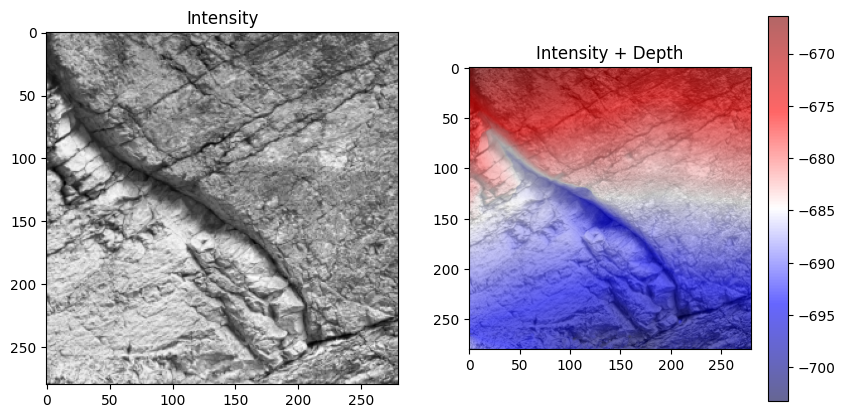

In [4]:
# Helper function to load .mat files
def load_mat_2d(path, key=None, dtype=np.float32, squeeze=True):
    path = Path(path)
    try:
        from scipy.io import loadmat
        mdict = loadmat(path)
        user_keys = [k for k in mdict.keys() if not k.startswith('__')]
        if key is None: key = user_keys[0]
        arr = mdict[key]
    except NotImplementedError:
        import h5py
        with h5py.File(path, "r") as f:
            available = list(f.keys())
            if key is None: key = available[0]
            arr = np.array(f[key])
    if squeeze: arr = np.squeeze(arr)
    return np.asarray(arr, dtype=dtype)

# Load and Preprocess
IMG_PATH = ortho_path
img = io.imread(IMG_PATH)
if img.ndim == 2: img_gray = img_as_float32(img)
else: img_gray = img_as_float32(color.rgb2gray(img))

Scale_Z = 100.0
F = 5 # Downsampling factor for speed
depth_raw = load_mat_2d(mne_path, key="mne")
depth_map = Scale_Z / F * depth_raw

# Resize
if img_gray.shape != depth_map.shape:
    depth_map = resize(depth_map, img_gray.shape, order=1, preserve_range=True)
new_shape = (img_gray.shape[0] // F, img_gray.shape[1] // F)
img_gray_small = resize(img_gray, new_shape, order=1, anti_aliasing=True, preserve_range=True)
depth_map_small = resize(depth_map, new_shape, order=1, anti_aliasing=True, preserve_range=True)

print(f"Processed shapes: Image {img_gray_small.shape}, Depth {depth_map_small.shape}")

# Visualize Inputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray_small, cmap='gray'); ax[0].set_title("Intensity")
ax[1].imshow(img_gray_small, cmap='gray')
im = ax[1].imshow(depth_map_small, cmap='seismic', alpha=0.6)
ax[1].set_title("Intensity + Depth")
plt.colorbar(im, ax=ax[1])
plt.show()


In [5]:
def run_pipeline(img_input, modality_name, custom_hessian=None):
    # 1. Hessian
    if custom_hessian is None:
        hessians = compute_hessians_per_scale(img_input, Σ)
        mods = {modality_name: hessians}
        weights = {modality_name: 1.0}
        fused_H = fuse_hessians_per_scale(mods, weights)
    else:
        fused_H = custom_hessian

    # 2. Graph
    coords, _, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, dark_ridges=dark_ridges)
    D = distances_from_similarity(S, mode="minus")
    if K == 2: D = triangle_connectivity_graph(coords, D)

    # 3. Extraction
    D_cc, idx_nodes = largest_connected_component(D)
    mask = np.zeros_like(img_input)
    if D_cc.shape[0] > 0:
        Dist = D_cc.copy(); Dist.setdiag(0.0)
        labels = hdbscan_from_sparse(Dist, min_cluster_size=min_cluster_size, allow_single_cluster=True)
        sub_coords = coords[idx_nodes]
        all_edges = []
        for lab in np.unique(labels):
            if lab < 0: continue
            cl = np.where(labels == lab)[0]
            if cl.size < 3: continue
            mst = mst_on_cluster(D_cc, cl)
            global_indices = idx_nodes[cl]
            S_cluster = S[global_indices, :][:, global_indices]
            nodes_kept, skel_graph = extract_backbone_centrality(mst, f_threshold=f_threshold, S=S_cluster, take_similarity=True)
            segs = skeleton_from_mst_graph(skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True)
            if segs.shape[0] > 0: all_edges.append(segs)
        if all_edges:
            fault_edges = np.vstack(all_edges)
            for e in fault_edges:
                r0, c0, r1, c1, _ = e
                rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
                rr, cc = np.clip(rr.astype(int), 0, mask.shape[0]-1), np.clip(cc.astype(int), 0, mask.shape[1]-1)
                mask[rr, cc] = 1.0
    return fused_H, mask


Processing Intensity...
Processing Depth...
Processing Fusion...


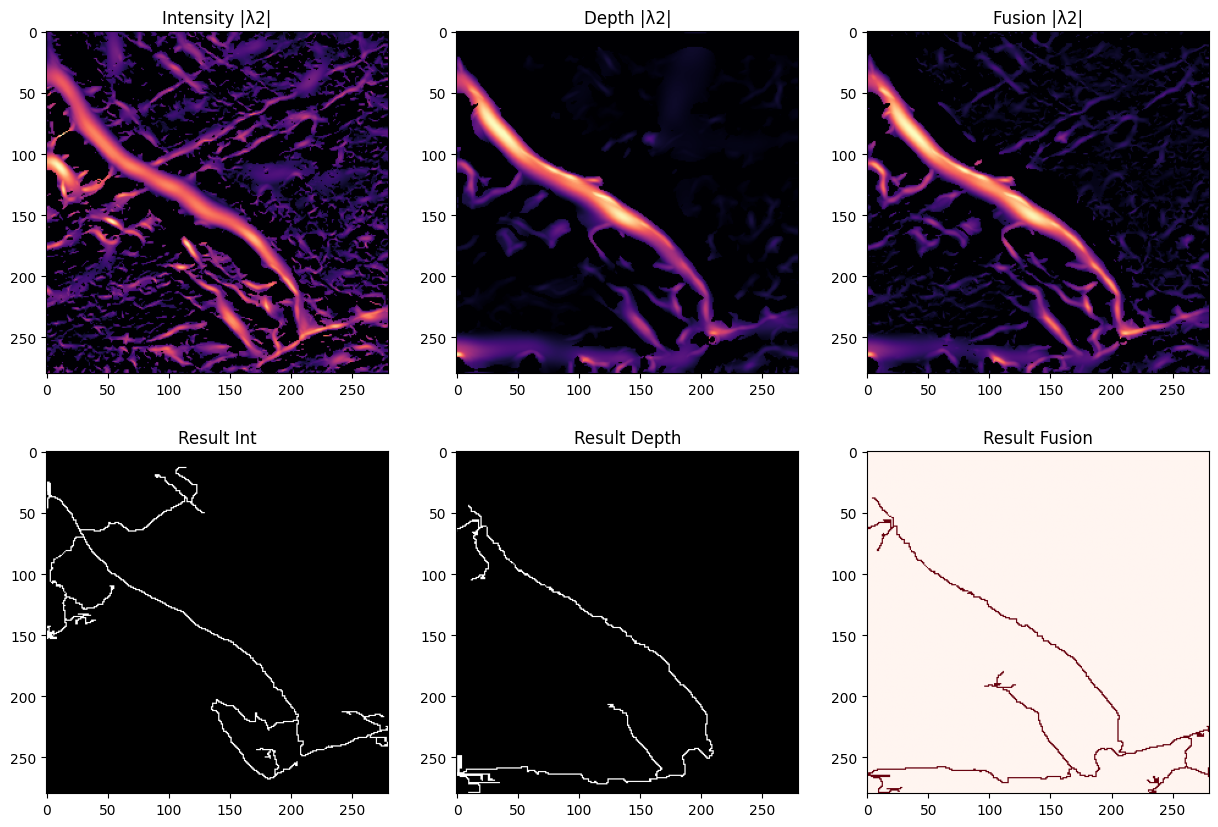

In [6]:
print("Processing Intensity...")
H_int, mask_int = run_pipeline(img_gray_small, "intensity")

print("Processing Depth...")
H_depth, mask_depth = run_pipeline(depth_map_small, "depth")

print("Processing Fusion...")
mods_fusion = {
    "intensity": compute_hessians_per_scale(img_gray_small, Σ),
    "depth": compute_hessians_per_scale(depth_map_small, Σ)
}
weights_fusion = {"intensity": 0.66, "depth": 0.33}
fused_H_final = fuse_hessians_per_scale(mods_fusion, weights_fusion)
_, mask_fusion = run_pipeline(img_gray_small, "fused", custom_hessian=fused_H_final)

# Visualize
def get_best_lambda2(hess_list):
    e2n_stack = np.stack([Hd['e2n'] for Hd in hess_list], axis=0)
    abs_e2n_stack = np.abs(e2n_stack)
    best_idx = abs_e2n_stack.argmax(axis=0)
    return np.take_along_axis(e2n_stack, best_idx[None,...], axis=0)[0]

l2_int = get_best_lambda2(H_int)
l2_depth = get_best_lambda2(H_depth)
l2_fusion = get_best_lambda2(fused_H_final)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0,0].imshow(np.clip(l2_int,0,1), cmap='magma'); axes[0,0].set_title("Intensity |λ2|")
axes[0,1].imshow(np.clip(l2_depth,0,1), cmap='magma'); axes[0,1].set_title("Depth |λ2|")
axes[0,2].imshow(np.clip(l2_fusion,0,1), cmap='magma'); axes[0,2].set_title("Fusion |λ2|")
axes[1,0].imshow(mask_int, cmap='gray'); axes[1,0].set_title("Result Int")
axes[1,1].imshow(mask_depth, cmap='gray'); axes[1,1].set_title("Result Depth")
axes[1,2].imshow(mask_fusion, cmap='Reds'); axes[1,2].set_title("Result Fusion")
plt.show()


## Part 2: FIND Dataset Benchmark


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [8]:
# Download FIND Dataset if not present
import zipfile
url = "https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK"
zip_path = "data.zip"
extract_dir = "data_find"
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if not os.path.exists(zip_path):
        gdown.download(url, zip_path, quiet=False)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_dir)
    print("Unzipped FIND dataset.")
else:
    print("FIND dataset already present.")


Downloading...
From (original): https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK
From (redirected): https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK&confirm=t&uuid=5c725d80-2d66-4fb4-8ced-c3cfd4c5d89b
To: /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/data.zip
100%|██████████| 1.15G/1.15G [00:19<00:00, 60.4MB/s]


Unzipped FIND dataset.


Analyzing image index 1...
Found: 2500 intensity, 2500 range, 2500 fused, 2500 filtered, 2500 labels.
Largest CC: 13897 nodes.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters: [-1  0] . 'Noise': 2796


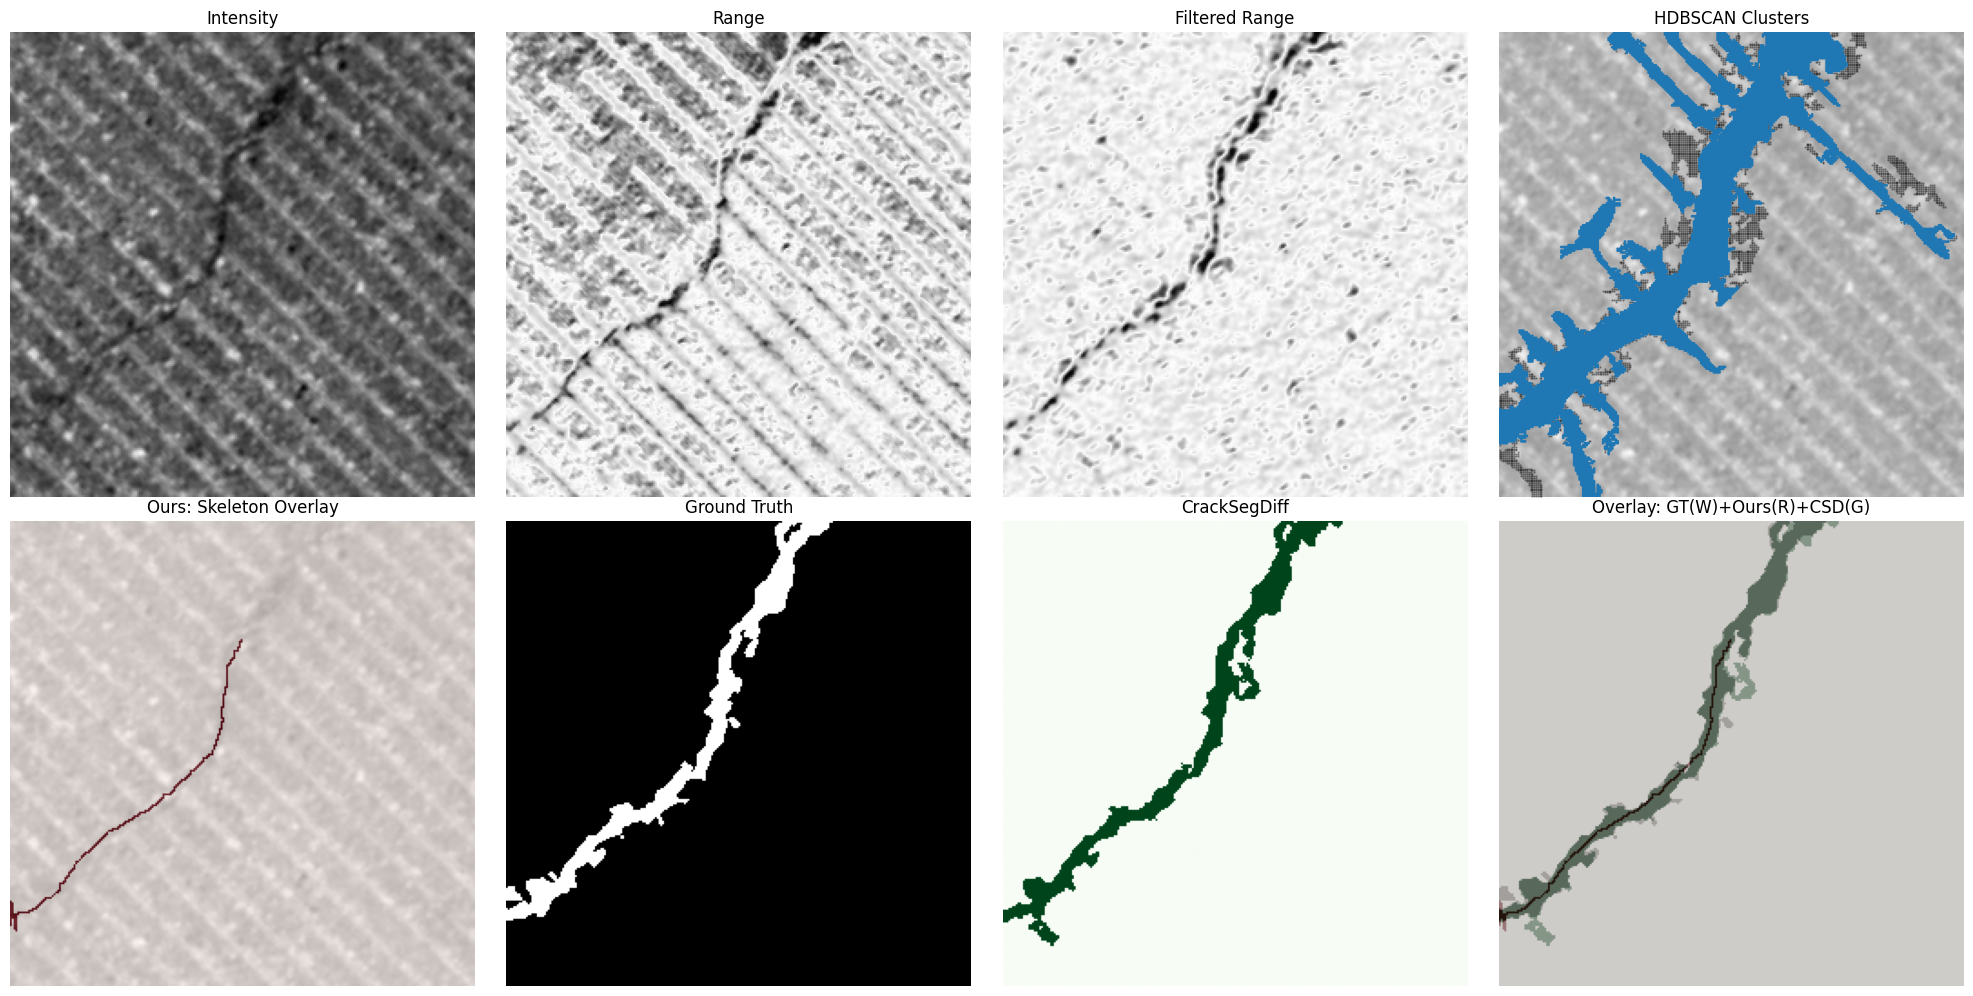

--- Metrics (Seed 1) ---
Jaccard: 0.38475390156050876
Tversky: 0.5215622457280221
Wasserstein: 39.36420138502026


In [15]:
# --- Single Example Analysis (Seed=1) ---
import hdbscan

seed = 1

print(f"Analyzing image index {seed}...")
struct = auto_discover_find_structure("data_find")
dat = load_modalities_and_gt_by_index(struct, seed)
base = dat["arrays"].get("intensity", next(iter(dat["arrays"].values())))
gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)

# 1. Compute Hessians & Fusion
mods_hess = {}
weights = {"intensity": 0.4, "range": 0.1, "filtered": 0.5, "fused": 0.0}
valid_keys = [k for k in weights if k in dat["arrays"] and weights[k] > 0]
for k in valid_keys: mods_hess[k] = compute_hessians_per_scale(to_gray(dat["arrays"][k]), Σ)
fused_H = fuse_hessians_per_scale(mods_hess, weights)

# 2. Graph Construction
coords, _, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, dark_ridges=dark_ridges)
D = distances_from_similarity(S, mode="minus")
if K == 2: D = triangle_connectivity_graph(coords, D)
D_cc, idx_nodes = largest_connected_component(D)

print(f"Largest CC: {D_cc.shape[0]} nodes.")

# 3. HDBSCAN Clustering
sub_coords = coords[idx_nodes]
if D_cc.shape[0] > 0:
    Dist = D_cc.copy()
    Dist.data = Dist.data ** expZ
    Dist = Dist.tocsr()
    Dist.setdiag(0.0)

    # Explicit HDBSCAN call as requested
    clusterer = hdbscan.HDBSCAN(
        metric="precomputed",
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        max_dist=max_dist,
        allow_single_cluster=allow_single_cluster,
    )
    labels = clusterer.fit_predict(Dist)

    # Detailed output
    print("Clusters:", np.unique(labels), ". 'Noise':", np.sum(labels == -1))
else:
    labels = np.array([])

# 4. Skeletonization (MST + Betweenness)
all_edges = []
sk_pred_mask = np.zeros_like(base, dtype=np.uint8)
if labels.size > 0:
    for lab in np.unique(labels):
        if lab < 0: continue
        cl = np.where(labels == lab)[0]
        if cl.size < 3: continue
        mst = mst_on_cluster(D_cc, cl)
        global_indices = idx_nodes[cl]
        S_cluster = S[global_indices, :][:, global_indices]
        nodes_kept, skel_graph = extract_backbone_centrality(mst, f_threshold=f_threshold, S=S_cluster, take_similarity=True)
        segs = skeleton_from_mst_graph(skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True)
        if segs.shape[0] > 0: all_edges.append(segs)
    if all_edges:
        fault_edges = np.vstack(all_edges)
        for e in fault_edges:
            r0, c0, r1, c1, _ = e
            rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
            rr, cc = np.clip(rr.astype(int), 0, sk_pred_mask.shape[0]-1), np.clip(cc.astype(int), 0, sk_pred_mask.shape[1]-1)
            sk_pred_mask[rr, cc] = 1

# 5. Visualizations
fig = plt.figure(figsize=(20, 10))

# A) Modalities
plt.subplot(2, 4, 1); plt.title("Intensity"); plt.imshow(dat["arrays"]["intensity"], cmap="gray"); plt.axis("off")
plt.subplot(2, 4, 2); plt.title("Range"); plt.imshow(dat["arrays"]["range"], cmap="gray"); plt.axis("off")
if 'filtered' in dat['arrays']:
    plt.subplot(2, 4, 3); plt.title("Filtered Range"); plt.imshow(dat["arrays"]["filtered"], cmap="gray"); plt.axis("off")

# B) HDBSCAN Clusters
ax_cl = plt.subplot(2, 4, 4); ax_cl.set_title("HDBSCAN Clusters")
ax_cl.imshow(base, cmap='gray', alpha=0.5)
if labels.size > 0:
    # Separate noise and clusters for visualization
    noise_mask = labels == -1
    cluster_mask = labels >= 0
    if np.any(noise_mask):
        ax_cl.scatter(sub_coords[noise_mask, 1], sub_coords[noise_mask, 0], c='k', s=0.5, alpha=0.3, label='Noise')
    if np.any(cluster_mask):
        ax_cl.scatter(sub_coords[cluster_mask, 1], sub_coords[cluster_mask, 0], c=labels[cluster_mask], cmap='tab20', s=1)
ax_cl.axis('off')

# C) Skeleton Overlay (Red)
ax_sk = plt.subplot(2, 4, 5); ax_sk.set_title("Ours: Skeleton Overlay")
ax_sk.imshow(base, cmap='gray')
ax_sk.imshow(sk_pred_mask, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
ax_sk.axis('off')

# D) Ground Truth
plt.subplot(2, 4, 6); plt.title("Ground Truth"); plt.imshow(gt, cmap="gray"); plt.axis("off")

# E) Comparison CrackSegDiff (if exists)
csd_path = f"/content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff/20000_1000/test_output_fused/im{seed+1:05d}_output_ens.png"
if os.path.exists(csd_path):
    try:
        csd_img = np.array(Image.open(csd_path).convert('L'))
        csd_bin = (csd_img > 127).astype(np.uint8)
        plt.subplot(2, 4, 7); plt.title("CrackSegDiff"); plt.imshow(csd_bin, cmap="Greens"); plt.axis("off")
        # F) Multi-Overlay
        ax_ov = plt.subplot(2, 4, 8); ax_ov.set_title("Overlay: GT(W)+Ours(R)+CSD(G)")
        ax_ov.imshow(np.zeros_like(base), cmap='gray')
        ax_ov.imshow(gt, cmap='Greys', alpha=0.5)
        ax_ov.imshow(sk_pred_mask, cmap='Reds', alpha=0.5)
        ax_ov.imshow(csd_bin, cmap='Greens', alpha=0.3)
        ax_ov.axis('off')
    except Exception as e: print("Error loading CSD:", e)
else:
    print("CrackSegDiff result not found at:", csd_path)

plt.tight_layout()
plt.show()

# Metrics for this image
sk_pred_thick = thicken(sk_pred_mask, pixels=3)
sk_gt_thick = thicken(skeletonize_lee(gt), pixels=3)
print("--- Metrics (Seed 1) ---")
print("Jaccard:", jaccard_index(sk_pred_thick, sk_gt_thick))
print("Tversky:", tversky_index(sk_pred_thick, sk_gt_thick, alpha=1.0, beta=0.5))
print("Wasserstein:", wasserstein_distance_skeletons(sk_pred_thick, sk_gt_thick))

In [ ]:
# --- Batch Processing 500 Images (USE_COMBO=True) ---
import itertools

excluded_ids = []
start_idx = 0
end_idx = 500
n_jobs = 8
USE_COMBO = True
allow_single_cluster = True
output_dir = "/content/drive/MyDrive/Datasets/FIND/Results/Avignon_Notebook_Batch"
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

def process_image_idx_combo(idx):
    if idx in excluded_ids: return None
    try:
        dat = load_modalities_and_gt_by_index(struct, idx)
        base = dat["arrays"].get("intensity", next(iter(dat["arrays"].values())))
        gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)
        gt = binary_closing(gt, footprint=disk(2))
        gt = binary_opening(gt, footprint=disk(2))
        sk_gt_thick = thicken(skeletonize_lee(gt), pixels=3)

        # Pre-compute Hessians (Normal & Inverted)
        hessian_cache = {}
        valid_keys = [k for k in weights if k in dat["arrays"] and weights[k] > 0]
        for k in valid_keys:
            arr = to_gray(dat["arrays"][k])
            h_norm = compute_hessians_per_scale(arr, Σ)
            hessian_cache[k] = [h_norm]
            if USE_COMBO:
                h_inv = compute_hessians_per_scale(255 - arr, Σ)
                hessian_cache[k].append(h_inv)

        # Combinations
        combo_indices = list(itertools.product([0, 1], repeat=len(valid_keys))) if USE_COMBO else [tuple(0 for _ in valid_keys)]

        best_tversky = -1.0
        best_res = None

        for combo in combo_indices:
            current_mods = {}
            for i, mod in enumerate(valid_keys):
                current_mods[mod] = hessian_cache[mod][combo[i]]

            fused_H = fuse_hessians_per_scale(current_mods, weights)
            coords, _, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, dark_ridges=dark_ridges)
            D = distances_from_similarity(S, mode="minus")
            if K == 2: D = triangle_connectivity_graph(coords, D)
            D_cc, idx_nodes = largest_connected_component(D)

            sk_pred = np.zeros_like(base, dtype=np.uint8)
            if D_cc.shape[0] > 0:
                expZ = 1
                Dist = D_cc.copy()
                Dist.data = Dist.data ** expZ
                Dist = Dist.tocsr()
                Dist.setdiag(0.0)

                # Explicit HDBSCAN call
                clusterer = hdbscan.HDBSCAN(
                    metric="precomputed",
                    min_cluster_size=min_cluster_size,
                    min_samples=1,
                    max_dist=1,
                    allow_single_cluster=allow_single_cluster,
                )
                labels = clusterer.fit_predict(Dist)

                sub_coords = coords[idx_nodes]
                all_edges = []
                for lab in np.unique(labels):
                    if lab < 0: continue
                    cl = np.where(labels == lab)[0]
                    if cl.size < 3: continue
                    mst = mst_on_cluster(D_cc, cl)
                    global_indices = idx_nodes[cl]
                    S_cluster = S[global_indices, :][:, global_indices]
                    nodes_kept, skel_graph = extract_backbone_centrality(mst, f_threshold=0.2, S=S_cluster, take_similarity=True)
                    segs = skeleton_from_mst_graph(skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True)
                    if segs.shape[0] > 0: all_edges.append(segs)
                if all_edges:
                    fault_edges = np.vstack(all_edges)
                    mask = np.zeros_like(base, dtype=np.uint8)
                    for e in fault_edges:
                        r0, c0, r1, c1, _ = e
                        rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
                        rr, cc = np.clip(rr.astype(int), 0, mask.shape[0]-1), np.clip(cc.astype(int), 0, mask.shape[1]-1)
                        mask[rr, cc] = 1
                    sk_pred = skeletonize_lee(mask)

            sk_pred_thick = thicken(sk_pred, pixels=3)
            tvs = tversky_index(sk_pred_thick, sk_gt_thick, alpha=1.0, beta=0.5)

            if tvs > best_tversky:
                best_tversky = tvs
                jac = jaccard_index(sk_pred_thick, sk_gt_thick)
                wass = wasserstein_distance_skeletons(sk_pred_thick, sk_gt_thick)
                best_res = {
                    "Image": f"im{idx+1:05d}",
                    "Jaccard": jac,
                    "Tversky": tvs,
                    "Wasserstein": wass,
                    "Combo": str(combo)
                }
        return best_res
    except Exception as e: return None

print(f"Processing batch {start_idx}-{end_idx}...")
with tqdm_joblib(tqdm(total=end_idx-start_idx)) as progress_bar:
    results = Parallel(n_jobs=n_jobs)(delayed(process_image_idx_combo)(i) for i in range(start_idx, end_idx))

results = [r for r in results if r is not None]
df_res = pd.DataFrame(results)
if not df_res.empty:
    print("\n--- Results ---")
    print(df_res[["Jaccard", "Tversky", "Wasserstein"]].mean())
    df_res.to_csv(os.path.join(output_dir, "metrics_combo.csv"), index=False)
else: print("No valid results.")
